### Plot depth-averaged upper 500 m speed

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import numpy as np
import matplotlib.path as mpath
from scipy.io import loadmat
import mat73
from xgcm import Grid

import warnings
warnings.simplefilter("ignore")

from dask.distributed import Client
from dask.distributed import LocalCluster 

cluster = LocalCluster()
client = Client(cluster) 
client

distributed.diskutils - INFO - Found stale lock file and directory '/net/Rebecca.Beadling/southern_ocean_fafmip/Beadling_2021_JGROceans_New/Figure_9/dask-worker-space/worker-0i4_h1_q', purging
distributed.diskutils - INFO - Found stale lock file and directory '/net/Rebecca.Beadling/southern_ocean_fafmip/Beadling_2021_JGROceans_New/Figure_9/dask-worker-space/worker-vcqu2u64', purging
distributed.diskutils - INFO - Found stale lock file and directory '/net/Rebecca.Beadling/southern_ocean_fafmip/Beadling_2021_JGROceans_New/Figure_9/dask-worker-space/worker-_cky6ugl', purging
distributed.diskutils - INFO - Found stale lock file and directory '/net/Rebecca.Beadling/southern_ocean_fafmip/Beadling_2021_JGROceans_New/Figure_9/dask-worker-space/worker-gwkisplo', purging
distributed.diskutils - INFO - Found stale lock file and directory '/net/Rebecca.Beadling/southern_ocean_fafmip/Beadling_2021_JGROceans_New/Figure_9/dask-worker-space/worker-_uty2vkw', purging
distributed.diskutils - INFO - Foun

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:42258/status,
Dashboard: http://127.0.0.1:42258/status,Workers: 4
Total threads: 8,Total memory: 30.94 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43900,Workers: 4
Dashboard: http://127.0.0.1:42258/status,Total threads: 8
Started: Just now,Total memory: 30.94 GiB
Comm: tcp://127.0.0.1:43077,Total threads: 2
Dashboard: http://127.0.0.1:32919/status,Memory: 7.73 GiB
Nanny: tcp://127.0.0.1:44306,


### Load time-averaged SOSE 1/12th output - this has been cropped to just values south of 60S

In [7]:
# Read .mat files as python dictionaries
dict_uvel_sose = mat73.loadmat('/archive/Rebecca.Beadling/SOSE_to_transfer_new/UvelForEllyn.mat')
dict_vvel_sose = mat73.loadmat('/archive/Rebecca.Beadling/SOSE_to_transfer_new/VvelForEllyn.mat')
dict_grid_sose = mat73.loadmat('/archive/Rebecca.Beadling/SOSE_to_transfer_new/grid.mat')

sose_u = xr.DataArray(dict_uvel_sose["U"],dims={"xg":dict_uvel_sose["xg"], "yc":dict_uvel_sose["yc"], "z":dict_uvel_sose["z"]})
sose_u = sose_u.assign_coords({"xg":dict_uvel_sose["xg"], "yc":dict_uvel_sose["yc"], "z":dict_uvel_sose["z"]})
sose_u = sose_u.transpose("z","yc","xg").chunk({'z':10})

sose_v = xr.DataArray(dict_vvel_sose["V"],dims={"xc":dict_vvel_sose["xc"], "yg":dict_vvel_sose["yg"], "z":dict_vvel_sose["z"]})
sose_v = sose_v.assign_coords({"xc":dict_vvel_sose["xc"], "yg":dict_vvel_sose["yg"], "z":dict_vvel_sose["z"]})
sose_v = sose_v.transpose("z","yg","xc").chunk({'z':10})

# Slice static fields to 643 points since the u and v output has been cropped
sose_depth = xr.DataArray(dict_grid_sose["Depth"],dims={"xg":sose_u["xg"], "yc":sose_u["yc"]})
sose_DRF = xr.DataArray(dict_grid_sose["DRF"],dims={"z":dict_uvel_sose["z"]})
sose_hFaCW = xr.DataArray(dict_grid_sose["hFacW"],dims=({"xg":sose_u["xg"], "yc":sose_u["yc"],"z":dict_uvel_sose["z"]}))

sose_depth = sose_depth.transpose("yc","xg").isel(yc=slice(0,643))
sose_hFacW = sose_hFaCW.transpose("z","yc","xg").isel(yc=slice(0,643))

sose_depth = sose_depth.assign_coords({"xg":sose_u["xg"],"yc":sose_u["yc"]})
sose_hFacW = sose_hFacW.assign_coords({"xg":sose_u["xg"],"yc":sose_u["yc"],"z":dict_uvel_sose["z"]})
sose_DRF = sose_DRF.assign_coords({"z":dict_uvel_sose["z"]}).chunk({'z':10})

## Put into single Dataset
sose_velocity = xr.Dataset({'sose_u':sose_u,
                            'sose_v':sose_v, 
                            'sose_depth':sose_depth,
                            'sose_hFacW':sose_hFacW,
                            'sose_DRF':sose_DRF},
                           coords={'xg':sose_u['xg'],
                                   'xc':sose_v['xc'],
                                   'yc':sose_u['yc'],
                                   'yg':sose_v['yg'],
                                   'z':sose_v['z']
                                  })

### Load piControl CM4 output for 100 yr period spanning model years 281 to 380

In [12]:
CM4_ocean_static = xr.open_dataset('/net/Rebecca.Beadling/subtropical_gyres/mode_water/ocean_monthly.static.nc')
CM4_v_cntrl = xr.open_dataset('/net2/Rebecca.Beadling/southern_ocean_fafmip/piControl_output/ocean_annual_z.0281-0380.vo.nc',
                    drop_variables=['average_DT', 'average_T1', 'average_T2']).sel(z_l=slice(0,500)).chunk({'time':10,'yq':188})
CM4_u_cntrl = xr.open_dataset('/net2/Rebecca.Beadling/southern_ocean_fafmip/piControl_output/ocean_annual_z.0281-0380.uo.nc',
                    drop_variables=['average_DT', 'average_T1', 'average_T2']).sel(z_l=slice(0,500)).chunk({'time':10,'yh':188})
CM4_velocity = xr.merge([CM4_v_cntrl,CM4_u_cntrl],compat='override')

### Load piControl ESM4 output for 100 yr period spanning model years 121 to 220

In [13]:
ESM4_ocean_static = xr.open_dataset('/net2/Rebecca.Beadling/southern_ocean_fafmip/ESM4/piControl/ocean_monthly.static.nc')
ESM4_v_cntrl = xr.open_dataset('/net2/Rebecca.Beadling/southern_ocean_fafmip/ESM4/piControl/ocean_annual_z.0121-0220.vo.nc',
                    drop_variables=['average_DT', 'average_T1', 'average_T2']).sel(z_l=slice(0,500)).chunk({'time':10,'yq':188})
ESM4_u_cntrl = xr.open_dataset('/net2/Rebecca.Beadling/southern_ocean_fafmip/ESM4/piControl/ocean_annual_z.0121-0220.uo.nc',
                    drop_variables=['average_DT', 'average_T1', 'average_T2']).sel(z_l=slice(0,500)).chunk({'time':10,'yh':188})
ESM4_velocity = xr.merge([ESM4_v_cntrl,ESM4_u_cntrl],compat='override')

### Compute 0 to 500 m depth-averaged (thickness weighted) ocean speed for SOSE. SOSE uses an Arakawa-C Grid, where tracers are located at the cell centers, u falls on the interface of the tracer cells in the zonal direction (left T cell face), and v falls on the interface of the tracer cell in the meridional direction (front T cell face). To compute speed, one must interpolate u or v onto the other position. We do this using xgcm.

<img
    src="https://mitgcm.readthedocs.io/en/latest/_images/cgrid3d.svg"
    width=200
/> 
<img
     src="https://xgcm.readthedocs.io/en/latest/_images/grid2d_hv.svg"
     width=400
/>

In [8]:
# create xgcm grid object
sose_grid = Grid(sose_velocity,
                 coords = {'X':{'center':'xc','left':'xg'},
                           'Y':{'center':'yc','left':'yg'},
                           'Z':{'center':'z'}}, periodic=['X','Y'])

# Interpolate v (xc, yg) in the Y direction so new dims are (xc,yc) 
# and then interpolate in X to get dimensions to (xg,yc), the same as u points.
sose_v = sose_grid.interp(sose_velocity.sose_v, 'Y', boundary='fill') 
sose_v = sose_grid.interp(sose_v,'X',boundary='fill')          

sose_v_sqr = xr.ufuncs.square(sose_v)
sose_u_sqr = xr.ufuncs.square(sose_velocity.sose_u)
speed_sose = xr.ufuncs.sqrt(sose_v_sqr + sose_u_sqr)

# Our speed points are on xg,yc, so for true thickness
# I need DRF (depth right face) * hFacW (thickness fraction west)
sose_thk = sose_velocity.sose_DRF * sose_velocity.sose_hFacW
sose_speed_weighted = speed_sose.sel(z=slice(-1,-500)).weighted(sose_thk.sel(z=slice(-1,-500)))
sose_speed_weighted_0_to_500_ave = sose_speed_weighted.mean(dim='z')*100  ## for cm s-1

### Compute 0 to 500 m depth-averaged (thickness weighted) ocean speed for CM4. The ocean component of CM4 and ESM4, MOM6, also uses an Arakawa-C Grid, so the same interpolation needs to be applied as done in SOSE in order to compute speed.

In [3]:
cm4_grid = Grid(CM4_velocity, coords={'X': {'center': 'xh', 'right': 'xq'},
                                      'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X','Y'])

cm4_v_cntrl = cm4_grid.interp(CM4_velocity.vo, 'Y', boundary='fill')
cm4_v_cntrl = cm4_grid.interp(cm4_v_cntrl,'X',boundary='fill') 

cm4_v_cntrl_sqr = xr.ufuncs.square(cm4_v_cntrl)
cm4_u_cntrl_sqr = xr.ufuncs.square(CM4_velocity.uo)
speed_cm4_cntrl = xr.ufuncs.sqrt(cm4_v_cntrl_sqr + cm4_u_cntrl_sqr)

## volume-weighted depth-average
cm4_volume = xr.open_dataset('/net2/Rebecca.Beadling/southern_ocean_fafmip/fafstress_output/ocean_annual_z.0001-0070.volcello.nc').isel(time=0)
## volume is on xh, yh - so we need to interpolate to xq, yh
cm4_vol = cm4_grid.interp(cm4_volume.volcello, 'X', boundary='fill')
cm4_vol_weights = cm4_vol.sel(z_l=slice(0,500)).fillna(0)
cm4_speed_weighted = speed_cm4_cntrl.sel(z_l=slice(0,500)).weighted(cm4_vol_weights)
cm4_speed_weighted_0_to_500_ave = cm4_speed_weighted.mean(dim=['z_l','time'])*100


### Compute 0 to 500 m depth-averaged (thickness weighted) ocean speed for ESM4. 

In [9]:
esm4_grid = Grid(ESM4_velocity, coords={'X': {'center': 'xh', 'right': 'xq'},
                                      'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X','Y'])

esm4_v_cntrl = esm4_grid.interp(ESM4_velocity.vo, 'Y', boundary='fill')
esm4_v_cntrl = esm4_grid.interp(esm4_v_cntrl,'X',boundary='fill') 

esm4_v_cntrl_sqr = xr.ufuncs.square(esm4_v_cntrl)
esm4_u_cntrl_sqr = xr.ufuncs.square(ESM4_velocity.uo)
speed_esm4_cntrl = xr.ufuncs.sqrt(esm4_v_cntrl_sqr + esm4_u_cntrl_sqr)

## volume-weighted depth-average
esm4_volume = xr.open_dataset('/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_annual_z/ts/annual/5yr/ocean_annual_z.1116-1120.volcello.nc').isel(time=0)
## volume is on xh, yh - so we need to interpolate to xq, yh
esm4_vol = esm4_grid.interp(esm4_volume.volcello, 'X', boundary='fill')
esm4_vol_weights = esm4_vol.sel(z_l=slice(0,500)).fillna(0)
esm4_speed_weighted = speed_esm4_cntrl.sel(z_l=slice(0,500)).weighted(esm4_vol_weights)
esm4_speed_weighted_0_to_500_ave = esm4_speed_weighted.mean(dim=['z_l','time'])*100

In [14]:
import sectionate
asc_20e_lat_1 = -70.5
asc_20e_lat_2 = -68.0
asc_20e_lon_1 = 20.0
asc_20e_lon_2 = 20.0

asc_150e_lat_1 = -69
asc_150e_lat_2 = -65.2
asc_150e_lon_1 = 150
asc_150e_lon_2 = 150

asc_130w_lat_1 = -75
asc_130w_lat_2 = -72
asc_130w_lon_1 = 230
asc_130w_lon_2 = 230

asc_80w_lat_1 = -74
asc_80w_lat_2 = -68
asc_80w_lon_1 = 280
asc_80w_lon_2 = 280

## SOSE
lat, lon = xr.broadcast(sose_velocity.yc,sose_velocity.xg)
i20e_sose, j20e_sose, x20e_sose, y20e_sose = sectionate.create_section(lon, 
                                                   lat,
                                                   asc_20e_lon_1,
                                                   asc_20e_lat_1,
                                                   asc_20e_lon_2,
                                                   asc_20e_lat_2)
i150e_sose, j150e_sose, x150e_sose, y150e_sose = sectionate.create_section(lon, 
                                                   lat,
                                                   asc_150e_lon_1,
                                                   asc_150e_lat_1,
                                                   asc_150e_lon_2,
                                                   asc_150e_lat_2)
i130w_sose, j130w_sose, x130w_sose, y130w_sose = sectionate.create_section(lon, 
                                                   lat,
                                                   asc_130w_lon_1,
                                                   asc_130w_lat_1,
                                                   asc_130w_lon_2,
                                                   asc_130w_lat_2)
i80w_sose, j80w_sose, x80w_sose, y80w_sose = sectionate.create_section(lon, 
                                                   lat,
                                                   asc_80w_lon_1,
                                                   asc_80w_lat_1,
                                                   asc_80w_lon_2,
                                                   asc_80w_lat_2)

## CM4
i20e_cm4, j20e_cm4, x20e_cm4, y20e_cm4 = sectionate.create_section(CM4_ocean_static.geolon, 
                                                   CM4_ocean_static.geolat,
                                                   asc_20e_lon_1,
                                                   asc_20e_lat_1,
                                                   asc_20e_lon_2,
                                                   asc_20e_lat_2)
i150e_cm4, j150e_cm4, x150e_cm4, y150e_cm4 = sectionate.create_section(CM4_ocean_static.geolon, 
                                                   CM4_ocean_static.geolat,
                                                   asc_150e_lon_1,
                                                   asc_150e_lat_1,
                                                   asc_150e_lon_2,
                                                   asc_150e_lat_2)
i130w_cm4, j130w_cm4, x130w_cm4, y130w_cm4 = sectionate.create_section(CM4_ocean_static.geolon, 
                                                   CM4_ocean_static.geolat,
                                                   asc_130w_lon_1,
                                                   asc_130w_lat_1,
                                                   asc_130w_lon_2,
                                                   asc_130w_lat_2)
i80w_cm4, j80w_cm4, x80w_cm4, y80w_cm4 = sectionate.create_section(CM4_ocean_static.geolon, 
                                                   CM4_ocean_static.geolat,
                                                   asc_80w_lon_1,
                                                   asc_80w_lat_1,
                                                   asc_80w_lon_2,
                                                   asc_80w_lat_2)

## ESM4
i20e_esm4, j20e_esm4, x20e_esm4, y20e_esm4 = sectionate.create_section(ESM4_ocean_static.geolon, 
                                                   ESM4_ocean_static.geolat,
                                                   asc_20e_lon_1,
                                                   asc_20e_lat_1,
                                                   asc_20e_lon_2,
                                                   asc_20e_lat_2)
i150e_esm4, j150e_esm4, x150e_esm4, y150e_esm4 = sectionate.create_section(ESM4_ocean_static.geolon, 
                                                   ESM4_ocean_static.geolat,
                                                   asc_150e_lon_1,
                                                   asc_150e_lat_1,
                                                   asc_150e_lon_2,
                                                   asc_150e_lat_2)
i130w_esm4, j130w_esm4, x130w_esm4, y130w_esm4 = sectionate.create_section(ESM4_ocean_static.geolon, 
                                                   ESM4_ocean_static.geolat,
                                                   asc_130w_lon_1,
                                                   asc_130w_lat_1,
                                                   asc_130w_lon_2,
                                                   asc_130w_lat_2)
i80w_esm4, j80w_esm4, x80w_esm4, y80w_esm4 = sectionate.create_section(ESM4_ocean_static.geolon, 
                                                   ESM4_ocean_static.geolat,
                                                   asc_80w_lon_1,
                                                   asc_80w_lat_1,
                                                   asc_80w_lon_2,
                                                   asc_80w_lat_2)

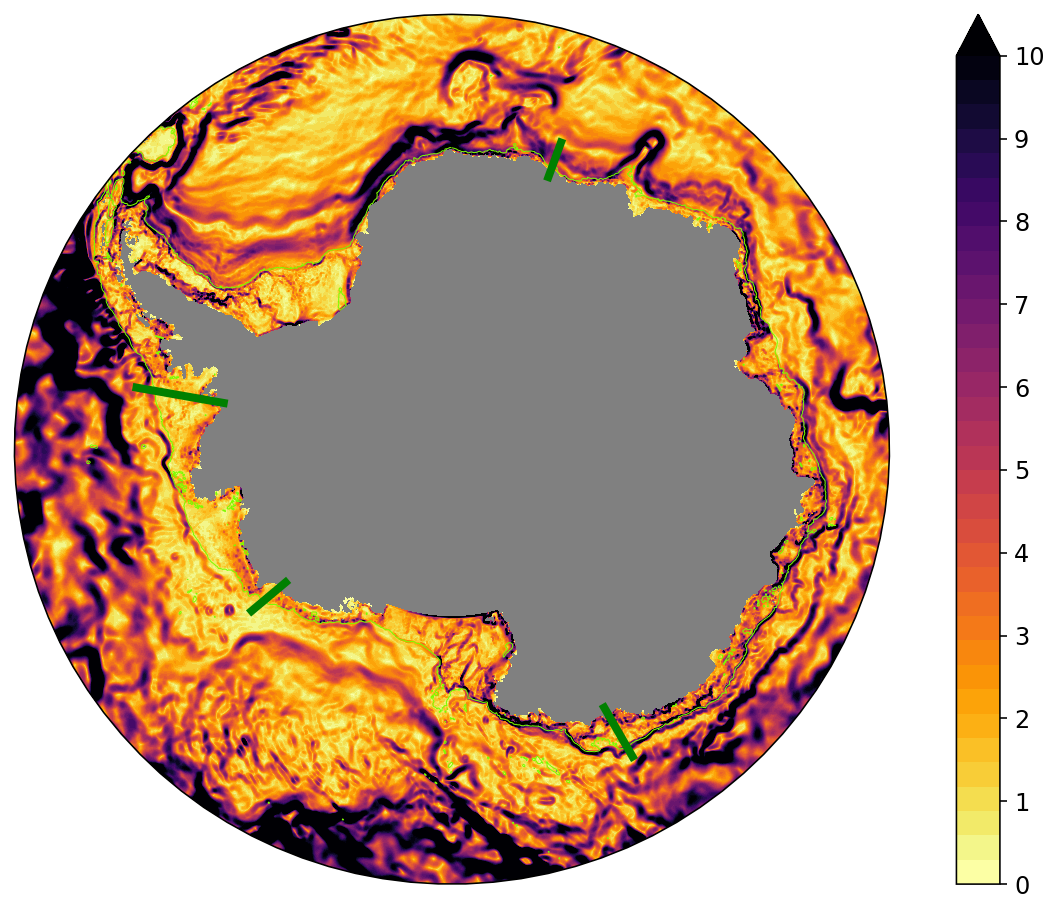

In [11]:
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

plt.figure(figsize=[12,8])

projection=ccrs.SouthPolarStereo(central_longitude = 0)
ax = plt.axes(projection=projection,facecolor='grey')
ax.set_extent([-180,180,-90,-60], ccrs.PlateCarree())
ax.set_boundary(circle,transform=ax.transAxes)

p = sose_speed_weighted_0_to_500_ave.where(sose_speed_weighted_0_to_500_ave>0).plot.contourf(x='xg', y='yc',vmin=0,vmax=10,levels=35,
                        transform=ccrs.PlateCarree(),cmap='inferno_r',add_colorbar=False)
sose_velocity.sose_depth.plot.contour(transform=ccrs.PlateCarree(),colors='lawngreen',levels=[1000],linewidths=0.50)

plt.plot(x20e_sose,y20e_sose,'-',color='green',linewidth=4,transform=ccrs.PlateCarree())
plt.plot(x150e_sose,y150e_sose,'-',color='green',linewidth=4,transform=ccrs.PlateCarree())
plt.plot(x130w_sose,y130w_sose,'-',color='green',linewidth=4,transform=ccrs.PlateCarree())
plt.plot(x80w_sose,y80w_sose,'-',color='green',linewidth=4,transform=ccrs.PlateCarree())

cb = plt.colorbar(p, ticks=[0,1,2,3,4,5,6,7,8,9,10])
cb.ax.tick_params(labelsize=12)

plt.savefig('SOSE_upper500m_Speed.pdf')

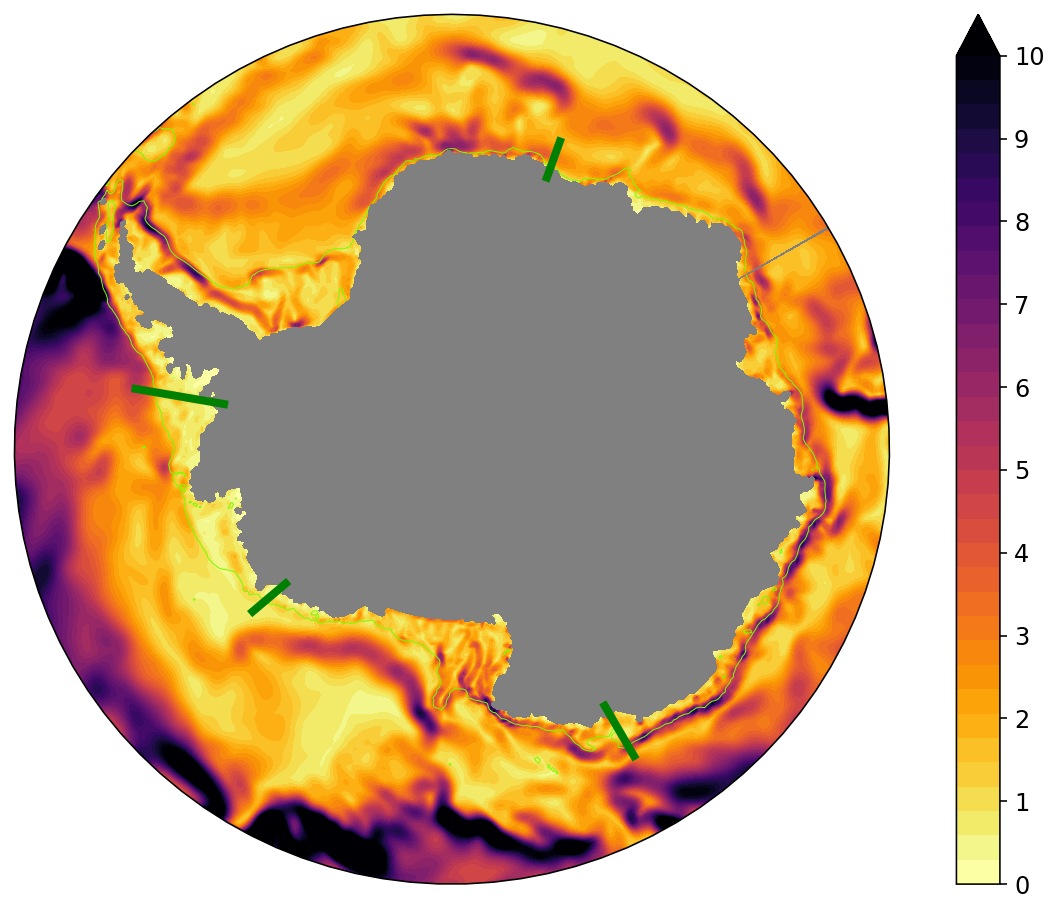

In [19]:
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

plt.figure(figsize=[12,8])

projection=ccrs.SouthPolarStereo(central_longitude = 0)
ax = plt.axes(projection=projection,facecolor='grey')
ax.set_extent([-180,180,-90,-60], ccrs.PlateCarree())
ax.set_boundary(circle,transform=ax.transAxes)

p = esm4_speed_weighted_0_to_500_ave.where(esm4_speed_weighted_0_to_500_ave>0).plot.contourf(x='xq', y='yh',vmin=0,vmax=10,levels=35,
                        transform=ccrs.PlateCarree(),cmap='inferno_r',add_colorbar=False)
ESM4_ocean_static.deptho.plot.contour(transform=ccrs.PlateCarree(),colors='lawngreen',levels=[1000],linewidths=0.50)

plt.plot(x20e_esm4,y20e_esm4,'-',color='green',linewidth=4,transform=ccrs.PlateCarree())
plt.plot(x150e_esm4,y150e_esm4,'-',color='green',linewidth=4,transform=ccrs.PlateCarree())
plt.plot(x130w_esm4,y130w_esm4,'-',color='green',linewidth=4,transform=ccrs.PlateCarree())
plt.plot(x80w_esm4,y80w_esm4,'-',color='green',linewidth=4,transform=ccrs.PlateCarree())

cb = plt.colorbar(p, ticks=[0,1,2,3,4,5,6,7,8,9,10])
cb.ax.tick_params(labelsize=12)

plt.savefig('ESM4_upper500m_Speed.pdf')

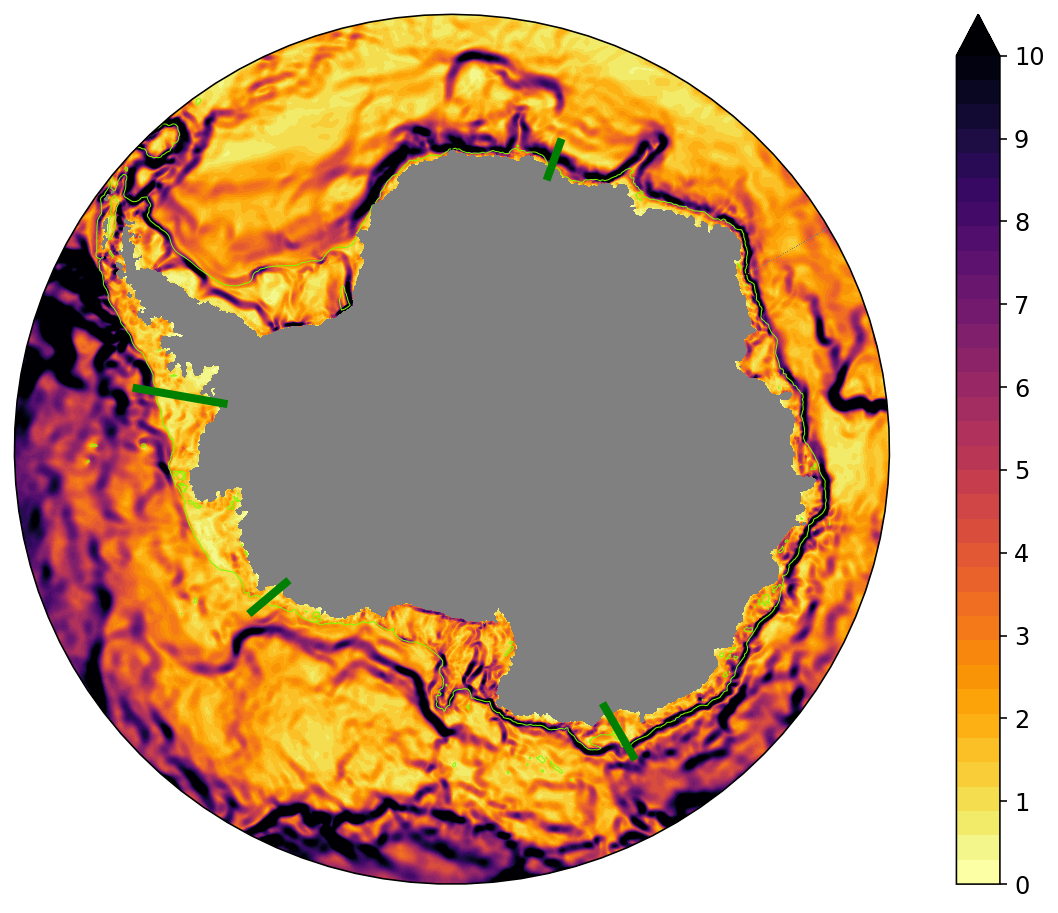

In [6]:
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

plt.figure(figsize=[12,8])

projection=ccrs.SouthPolarStereo(central_longitude = 0)
ax = plt.axes(projection=projection,facecolor='grey')
ax.set_extent([-180,180,-90,-60], ccrs.PlateCarree())
ax.set_boundary(circle,transform=ax.transAxes)

p = cm4_speed_weighted_0_to_500_ave.where(cm4_speed_weighted_0_to_500_ave>0).plot.contourf(x='xq', y='yh',vmin=0,vmax=10,levels=35,
                        transform=ccrs.PlateCarree(),cmap='inferno_r',add_colorbar=False)
CM4_ocean_static.deptho.plot.contour(transform=ccrs.PlateCarree(),colors='lawngreen',levels=[1000],linewidths=0.50)

plt.plot(x20e_cm4,y20e_cm4,'-',color='green',linewidth=4,transform=ccrs.PlateCarree())
plt.plot(x150e_cm4,y150e_cm4,'-',color='green',linewidth=4,transform=ccrs.PlateCarree())
plt.plot(x130w_cm4,y130w_cm4,'-',color='green',linewidth=4,transform=ccrs.PlateCarree())
plt.plot(x80w_cm4,y80w_cm4,'-',color='green',linewidth=4,transform=ccrs.PlateCarree())

cb = plt.colorbar(p, ticks=[0,1,2,3,4,5,6,7,8,9,10])
cb.ax.tick_params(labelsize=12)

plt.savefig('CM4_upper500m_Speed.pdf')